In [1]:
# load necessary library
suppressPackageStartupMessages(library(GEOquery))
suppressPackageStartupMessages(library(oligo))

In [2]:
create.folders<-function(folder_names=NULL,location="."){
#     pass names or paths to create multiple folders 
#     and returns list of status as boolean

    paths<-file.path(location, folder_names)
    is_exists<-dir.exists(paths)
    paths<-paths[!is_exists]
    lapply(paths,function(path){
        dir.create(path, recursive = TRUE)
    })
    return(!is_exists)
    
}

remove.folders<-function(location=".",folder_names=NULL){
#   pass names or paths to remove multiple folders  
#   and returns list of boolean, if it now exists 
    
    paths<-file.path(location, folder_names)
    unlink(paths, recursive= T)
    return(!dir.exists(paths))
}

find.all.indeces<-function(query_list, vector){  
#   returns all matched indeces as a list.
    sapply(query_list,function(query) grep(query,vector))
}
           
extract_from_vector<-function(query_list, vector){
    store<-unique(unlist(lapply(query_list, function(query) grep(query, vector))
                  ))
    return(vector[store])
}
           
group_by_query<-function(query_names, vector, group_names=NULL){
#     it allocates group with first group name that matched if provided.
#     Otherwise allocate query name
    group<-rep(NA,length(vector))
    for(i in 1:length(vector)){
        for(j in 1:length(query_names)){
            if(is.na(group[i]) && !is.na(pmatch(query_names[j],vector[i])))
                if(!is.null(group_names) &&
                   length(group_names)==length(query_names))
                    group[i]<-group_names[j]
                else{group[i]<-query_names[j]}
            }
        }
      return(group)  
}
           
# if group_by_query fuction don't works due to query issues the use this
group_by_numbering<-function(group_numbering, vector, group_names=NULL){
#     gsub(pattern, replacement, string)
    group_numbering<- gsub(" ","",group_numbering)
    group <- rep(NA,length(vector))
    for (i in 1:nchar(group_numbering)){
        num<-as.numeric(substr(group_numbering,i,i))
        if(is.null(group_names)) 
            group[i] <- num
        else group[i] <- group_names[num]
        }
    return(group)
}
           
group_by_uniqueness<- function(vector, group_names=NULL){
    if(is.null(group_names)){
        uniq<- unique(vector)
        rename<-1:length(uniq)
        names(rename)<-uniq
        return(unname(rename[vector]))
    } 
    else {
        uniq<- unique(vector)
        names(group_names)<-uniq
        return(unname(group_names[vector]))
    }
}

fetch.geo.data<-function(GEO,filename=NULL,store_loc="."){
#     fetch published processed data and metadata from GEO database
    suppressPackageStartupMessages(library(GEOquery))
    if(!is.null(filename)) create.folders(file.path(store_loc,filename))
    else create.folders(filename)
    geo.data <- getGEO(GEO, filename=filename, destdir=store_loc, 
                     GSEMatrix=FALSE, AnnotGPL=TRUE, 
                     getGPL=TRUE)
    return(geo.data)
}

need.log.transformation<- function(data){
    qx <- as.numeric(quantile(data, c(0., 0.25, 0.5, 0.75, 0.99, 1.0), na.rm=T))
    # check if data need to be normalized 
    LogC <- (qx[5] > 100) ||
            (qx[6]-qx[1] > 50 && qx[2] > 0) ||
            (qx[2] > 0 && qx[2] < 1 && qx[4] > 1 && qx[4] < 2)
    return(LogC)
}

sort.data<- function(data,columns,dec=FALSE){
    return(data[order(data[,columns],decreasing=dec),])
}

del.duplication<- function(data,column){
    return(data[!duplicated(data[,column]),])
}
           
setup_folder<-function(id){
    # create and set working directory if not exists
    if(!identical(tail(unlist(strsplit(getwd(), split = "/")), n=1), id)){
        if(!dir.exists(id)) {
        create.folders(id)
        setwd(dir =id )
    }
    else setwd(dir =id )
} 
}

In [9]:
# setwd('./GSE68667_P.falci_mosquito/')
# setwd('..')
getwd()

[1] "D:/biological data analysis/Parasites/GSE68667_P.falci_mosquito"

In [8]:
# declare ccession number
# my.gse<-c("GSE68667")
# set working directory
# setup_folder(my.gse)
# getwd()

[1] "D:/biological data analysis/Parasites/GSE68667_P.falci_mosquito/GSE68667"

# Using GEOquery to Obtain Microarray Data<br>

The GEOquery package allows you to programmatically access data from GEO. Depending on your needs, you can download only the processed data and metadata provided by the depositor. In some cases, you may want to download the raw data as well, if it was provided by the depositor.

In [10]:
# create directory to store files downloaded from GEO and results anlyzed
create.folders(c("geo_downloads","results"))

[1] FALSE FALSE

# Preparing the Phenodata

In [11]:
samples<-c("PfBloodR1","PfBloodR2",
           "PfOocystR1","PfOocystR2",
           "PfSporozoiteR1","PfSporozoiteR2"
            )
pdata.custom<-DataFrame(samples=samples)
rownames(pdata.custom)<-pdata.custom$samples
head(pdata.custom)

DataFrame with 6 rows and 1 column
                      samples
                  <character>
PfBloodR1           PfBloodR1
PfBloodR2           PfBloodR2
PfOocystR1         PfOocystR1
PfOocystR2         PfOocystR2
PfSporozoiteR1 PfSporozoiteR1
PfSporozoiteR2 PfSporozoiteR2

In [12]:
# make data frame of phenotypic Data
my.pdata <- as.data.frame(pdata.custom, stringsAsFactors=F)
head(my.pdata,2)

,samples
,<chr>
PfBloodR1,PfBloodR1
PfBloodR2,PfBloodR2


In [13]:
my.pdata

,samples
,<chr>
PfBloodR1,PfBloodR1
PfBloodR2,PfBloodR2
PfOocystR1,PfOocystR1
PfOocystR2,PfOocystR2
PfSporozoiteR1,PfSporozoiteR1
PfSporozoiteR2,PfSporozoiteR2


In [14]:
# group_num<-1:length(24)
group_names<-c("PfBlood","PfSporozoite","PfOocyst")
# allocate groups
my.pdata[["group"]]<-group_by_query(group_names,my.pdata$samples, group_names)
# num of replicates in each group
table(my.pdata$group)


     PfBlood     PfOocyst PfSporozoite 
           2            2            2 

In [15]:
my.pdata

,samples,group
,<chr>,<chr>
PfBloodR1,PfBloodR1,PfBlood
PfBloodR2,PfBloodR2,PfBlood
PfOocystR1,PfOocystR1,PfOocyst
PfOocystR2,PfOocystR2,PfOocyst
PfSporozoiteR1,PfSporozoiteR1,PfSporozoite
PfSporozoiteR2,PfSporozoiteR2,PfSporozoite


In [16]:
suppressPackageStartupMessages(library(RColorBrewer))
# select colour for each group
group.color <- brewer.pal(7, "Dark2")
names(group.color)<-unique(my.pdata$group)
# allocate colour to each sample
sample.color <- unname(group.color[my.pdata$group])
my.pdata[["color"]]<- sample.color
sample.color

[1] "#1B9E77" "#1B9E77" "#D95F02" "#D95F02" "#7570B3" "#7570B3"

In [17]:
# store processed phenotype data
write.table(my.pdata, file=paste0("results/",my.gse,"_PhenoData.txt"), 
            sep="\t", quote=F,col.names=NA)

# Preparing Gene Expression Data<br>

## Normalize Expression Data

In [21]:
exprs.data<-read.table("geo_downloads/GSE68667_PfStages.txt",header=T,sep="\t",quote="")

In [22]:
head(exprs.data)

,PlasmoDB_GeneID,Antisense.PfBloodR1,Antisense.PfBloodR2,Antisense.PfOocystR1,Antisense.PfOocystR2,Antisense.PfSporozoiteR1,Antisense.PfSporozoiteR2,Sense.PfBloodR1,Sense.PfBloodR2,Sense.PfOocystR1,Sense.PfOocystR2,Sense.PfSporozoiteR1,Sense.PfSporozoiteR2
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,PF3D7_0103800,0.000000,1.939313,0.000000,0.4206456,2.450488,2.040657,7.67209,43.773647,0.8908762,2.0703688,0.00000,0.000000
2,PF3D7_0103900,2.845652,6.787595,11.477942,9.2542024,22.054388,28.569191,38.36045,78.063003,120.2682825,87.2512574,17.36391,9.466673
3,PF3D7_0104000,11.382607,22.302098,1.147794,0.0000000,29.405850,32.650504,0.00000,2.918243,3.5635047,0.5915339,3594.32852,3921.569336
4,PF3D7_0104100,0.000000,1.939313,1.147794,0.0000000,56.361213,37.752145,19.94743,34.289357,2.6726285,1.1830679,4714.30046,4757.003238
5,PF3D7_0104200,0.000000,0.000000,1.147794,1.2619367,12.252438,9.182954,24.55069,20.427702,16.9266472,22.1825231,208.36687,239.033496
6,PF3D7_0104300,14.228259,5.817939,11.477942,13.4606580,9.801950,16.325252,287.70337,93.383780,87.3058643,69.5052389,295.18640,359.733578


In [23]:
rownames(exprs.data)<- exprs.data$PlasmoDB_GeneID
head(exprs.data)

,PlasmoDB_GeneID,Antisense.PfBloodR1,Antisense.PfBloodR2,Antisense.PfOocystR1,Antisense.PfOocystR2,Antisense.PfSporozoiteR1,Antisense.PfSporozoiteR2,Sense.PfBloodR1,Sense.PfBloodR2,Sense.PfOocystR1,Sense.PfOocystR2,Sense.PfSporozoiteR1,Sense.PfSporozoiteR2
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PF3D7_0103800,PF3D7_0103800,0.000000,1.939313,0.000000,0.4206456,2.450488,2.040657,7.67209,43.773647,0.8908762,2.0703688,0.00000,0.000000
PF3D7_0103900,PF3D7_0103900,2.845652,6.787595,11.477942,9.2542024,22.054388,28.569191,38.36045,78.063003,120.2682825,87.2512574,17.36391,9.466673
PF3D7_0104000,PF3D7_0104000,11.382607,22.302098,1.147794,0.0000000,29.405850,32.650504,0.00000,2.918243,3.5635047,0.5915339,3594.32852,3921.569336
PF3D7_0104100,PF3D7_0104100,0.000000,1.939313,1.147794,0.0000000,56.361213,37.752145,19.94743,34.289357,2.6726285,1.1830679,4714.30046,4757.003238
PF3D7_0104200,PF3D7_0104200,0.000000,0.000000,1.147794,1.2619367,12.252438,9.182954,24.55069,20.427702,16.9266472,22.1825231,208.36687,239.033496
PF3D7_0104300,PF3D7_0104300,14.228259,5.817939,11.477942,13.4606580,9.801950,16.325252,287.70337,93.383780,87.3058643,69.5052389,295.18640,359.733578


In [144]:
# check if data need to be normalized 
LogC<-need.log.transformation(exprs.data[,-1])
LogC

[1] TRUE

In [182]:
table(exprs.data[,-1]<=0)


FALSE  TRUE 
46334 22546 

In [145]:
assayData<- as.matrix(exprs.data[,-1])
head(assayData)

,Antisense.PfBloodR1,Antisense.PfBloodR2,Antisense.PfOocystR1,Antisense.PfOocystR2,Antisense.PfSporozoiteR1,Antisense.PfSporozoiteR2,Sense.PfBloodR1,Sense.PfBloodR2,Sense.PfOocystR1,Sense.PfOocystR2,Sense.PfSporozoiteR1,Sense.PfSporozoiteR2
PF3D7_0103800,0.000000,1.939313,0.000000,0.4206456,2.450488,2.040657,7.67209,43.773647,0.8908762,2.0703688,0.00000,0.000000
PF3D7_0103900,2.845652,6.787595,11.477942,9.2542024,22.054388,28.569191,38.36045,78.063003,120.2682825,87.2512574,17.36391,9.466673
PF3D7_0104000,11.382607,22.302098,1.147794,0.0000000,29.405850,32.650504,0.00000,2.918243,3.5635047,0.5915339,3594.32852,3921.569336
PF3D7_0104100,0.000000,1.939313,1.147794,0.0000000,56.361213,37.752145,19.94743,34.289357,2.6726285,1.1830679,4714.30046,4757.003238
PF3D7_0104200,0.000000,0.000000,1.147794,1.2619367,12.252438,9.182954,24.55069,20.427702,16.9266472,22.1825231,208.36687,239.033496
PF3D7_0104300,14.228259,5.817939,11.477942,13.4606580,9.801950,16.325252,287.70337,93.383780,87.3058643,69.5052389,295.18640,359.733578


In [146]:
assayData<-assayData[,rownames(my.pdata)]
head(assayData)

,Antisense.PfBloodR1,Antisense.PfBloodR2,Sense.PfBloodR1,Sense.PfBloodR2,Antisense.PfOocystR1,Antisense.PfOocystR2,Sense.PfOocystR1,Sense.PfOocystR2,Antisense.PfSporozoiteR1,Antisense.PfSporozoiteR2,Sense.PfSporozoiteR1,Sense.PfSporozoiteR2
PF3D7_0103800,0.000000,1.939313,7.67209,43.773647,0.000000,0.4206456,0.8908762,2.0703688,2.450488,2.040657,0.00000,0.000000
PF3D7_0103900,2.845652,6.787595,38.36045,78.063003,11.477942,9.2542024,120.2682825,87.2512574,22.054388,28.569191,17.36391,9.466673
PF3D7_0104000,11.382607,22.302098,0.00000,2.918243,1.147794,0.0000000,3.5635047,0.5915339,29.405850,32.650504,3594.32852,3921.569336
PF3D7_0104100,0.000000,1.939313,19.94743,34.289357,1.147794,0.0000000,2.6726285,1.1830679,56.361213,37.752145,4714.30046,4757.003238
PF3D7_0104200,0.000000,0.000000,24.55069,20.427702,1.147794,1.2619367,16.9266472,22.1825231,12.252438,9.182954,208.36687,239.033496
PF3D7_0104300,14.228259,5.817939,287.70337,93.383780,11.477942,13.4606580,87.3058643,69.5052389,9.801950,16.325252,295.18640,359.733578


In [147]:
if (LogC) { 
    assayData[which(assayData<= 0)] <- NaN
    # take log2 transform
    assayData<-na.omit(log2(assayData))
}
# prpare an Expression Set
my.rma<-ExpressionSet(assayData=assayData,
                     phenoData=AnnotatedDataFrame(as.data.frame(my.pdata))
                     )
head(exprs(my.rma),3)

,Antisense.PfBloodR1,Antisense.PfBloodR2,Sense.PfBloodR1,Sense.PfBloodR2,Antisense.PfOocystR1,Antisense.PfOocystR2,Sense.PfOocystR1,Sense.PfOocystR2,Antisense.PfSporozoiteR1,Antisense.PfSporozoiteR2,Sense.PfSporozoiteR1,Sense.PfSporozoiteR2
PF3D7_0103900,1.508759,2.762901,5.261548,6.286567,3.520792,3.210109,6.910112,6.447104,4.462994,4.836388,4.118020,3.242858
PF3D7_0104300,3.830687,2.540508,8.168438,6.545100,3.520792,3.750677,6.448007,6.119050,3.293069,4.029033,8.205482,8.490785
PF3D7_0104800,3.678684,4.125471,2.617692,3.352455,2.198864,1.920602,6.477153,6.559945,1.293069,3.198958,9.677715,9.617897


In [148]:
# save expression values
write.table(exprs(my.rma), file=paste0("results/",my.gse,"_NormExprsData.txt"),
            sep="\t", quote=FALSE, col.names=NA)

## Check Normalization

In [118]:
suppressPackageStartupMessages(library(limma))

In [119]:
create.folders(c("results/SamplesPlot"))

[1] FALSE

In [151]:
head(assayData)

,Antisense.PfBloodR1,Antisense.PfBloodR2,Sense.PfBloodR1,Sense.PfBloodR2,Antisense.PfOocystR1,Antisense.PfOocystR2,Sense.PfOocystR1,Sense.PfOocystR2,Antisense.PfSporozoiteR1,Antisense.PfSporozoiteR2,Sense.PfSporozoiteR1,Sense.PfSporozoiteR2
PF3D7_0103900,1.508759,2.7629005,5.261548,6.286567,3.520792,3.210109,6.910112,6.447104,4.4629938,4.836388,4.118020,3.242858
PF3D7_0104300,3.830687,2.5405081,8.168438,6.545100,3.520792,3.750677,6.448007,6.119050,3.2930688,4.029033,8.205482,8.490785
PF3D7_0104800,3.678684,4.1254706,2.617692,3.352455,2.198864,1.920602,6.477153,6.559945,1.2930688,3.198958,9.677715,9.617897
PF3D7_0104900,1.508759,1.9555456,7.469441,6.715025,4.520792,4.704873,7.926054,7.253760,3.4629938,3.836388,8.577451,8.774239
PF3D7_0105600,1.508759,-0.0444544,5.640059,4.867028,1.783826,2.210109,5.387886,5.480938,3.6149969,3.350961,9.205482,9.143724
PF3D7_0105700,1.508759,2.2774737,5.109545,6.068662,3.368789,3.879960,7.678787,7.825616,0.2930688,1.029033,6.992489,6.797446


In [152]:
head(exprs(my.rma))

,Antisense.PfBloodR1,Antisense.PfBloodR2,Sense.PfBloodR1,Sense.PfBloodR2,Antisense.PfOocystR1,Antisense.PfOocystR2,Sense.PfOocystR1,Sense.PfOocystR2,Antisense.PfSporozoiteR1,Antisense.PfSporozoiteR2,Sense.PfSporozoiteR1,Sense.PfSporozoiteR2
PF3D7_0103900,1.508759,2.7629005,5.261548,6.286567,3.520792,3.210109,6.910112,6.447104,4.4629938,4.836388,4.118020,3.242858
PF3D7_0104300,3.830687,2.5405081,8.168438,6.545100,3.520792,3.750677,6.448007,6.119050,3.2930688,4.029033,8.205482,8.490785
PF3D7_0104800,3.678684,4.1254706,2.617692,3.352455,2.198864,1.920602,6.477153,6.559945,1.2930688,3.198958,9.677715,9.617897
PF3D7_0104900,1.508759,1.9555456,7.469441,6.715025,4.520792,4.704873,7.926054,7.253760,3.4629938,3.836388,8.577451,8.774239
PF3D7_0105600,1.508759,-0.0444544,5.640059,4.867028,1.783826,2.210109,5.387886,5.480938,3.6149969,3.350961,9.205482,9.143724
PF3D7_0105700,1.508759,2.2774737,5.109545,6.068662,3.368789,3.879960,7.678787,7.825616,0.2930688,1.029033,6.992489,6.797446


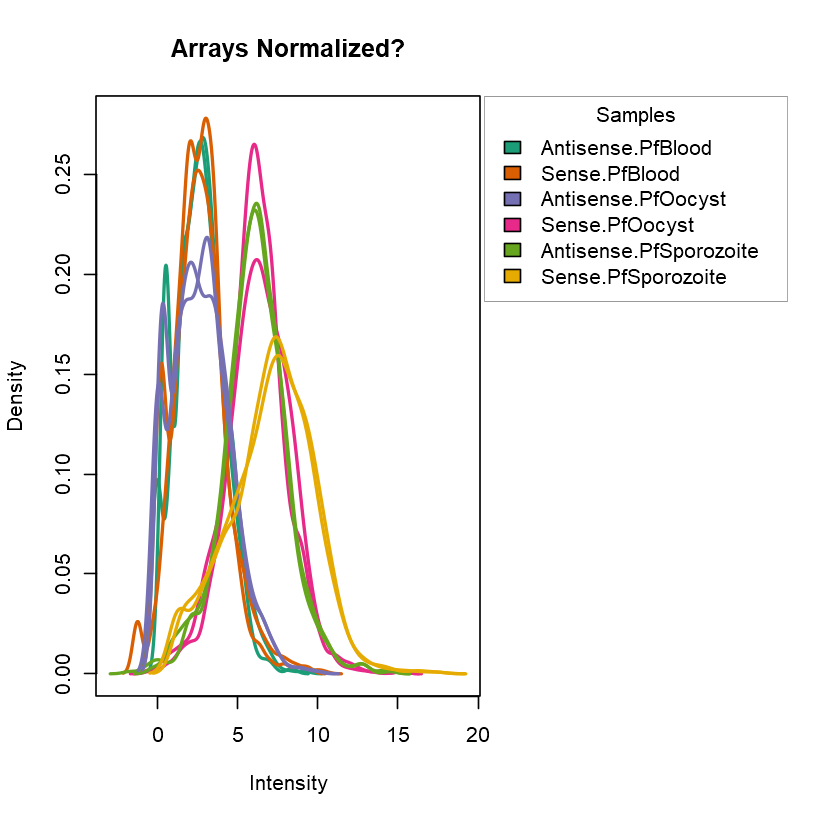

In [160]:
# svg("results/SamplesPlot/DensityPlot.svg")
par(mar=c(6,4,4,15),xpd=TRUE)
plotDensities(exprs(my.rma), legend=F, col=sample.color, main="Arrays Normalized?")
legend("topright",title="Samples",inset=c(-0.80,0),box.lwd=0.2, 
       legend=unique(pData(my.rma)$group), fill=group.color)
# dev.off()

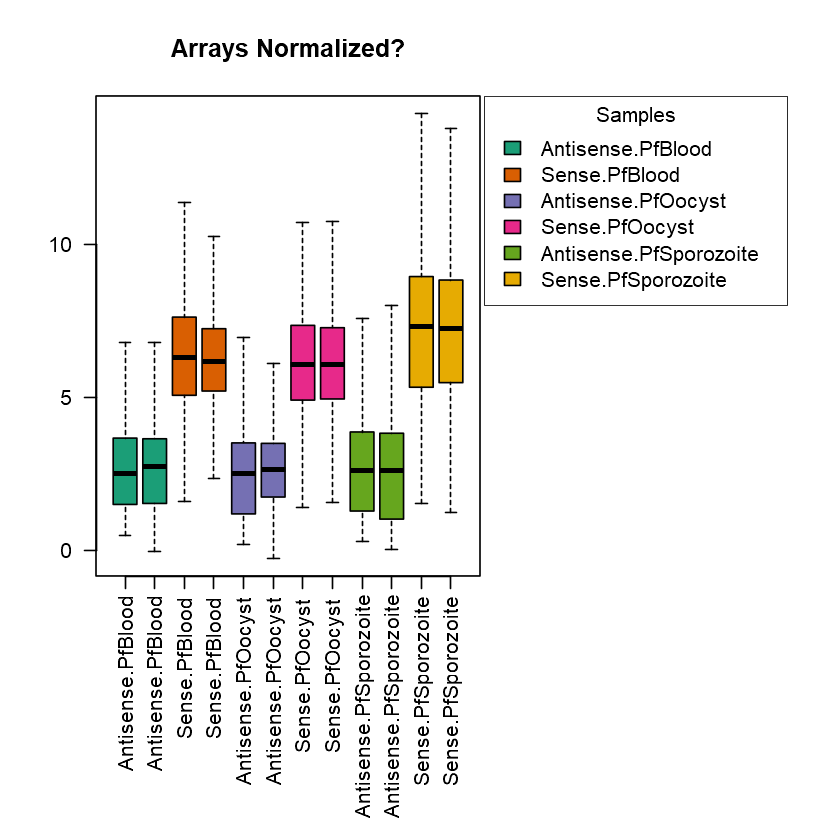

In [170]:
# svg("results/SamplesPlot/BoxPlot.svg")
par(mar=c(11,4,4,15),xpd=TRUE)
boxplot(exprs(my.rma), las=2, names=pData(my.rma)$group, 
        outline=F, col=sample.color, main="Arrays Normalized?")
legend("topright",title="Samples",inset=c(-0.80,0),box.lwd=0.5, 
       legend=unique(pData(my.rma)$group), fill=group.color)
# dev.off()

## Checking variation across sample<br>
we are mainly checking for consistency between biological replicates of the same treatment.

### Principle component analysis

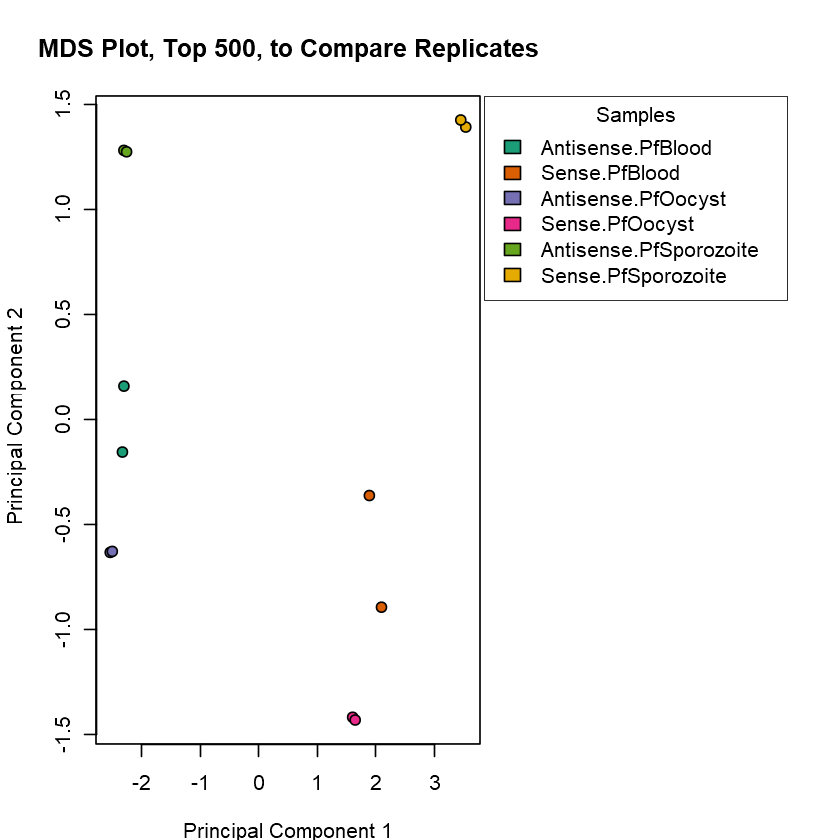

In [174]:
# svg("results/SamplesPlot/PCA_Plot.svg")
par(mar=c(4,4,4,15),xpd=TRUE)
limma::plotMDS(exprs(my.rma),top=500, pch=rep(21, 7), 
         bg=sample.color, gene.selection="common", 
        main="MDS Plot, Top 500, to Compare Replicates",
#         labels=unique(pData(my.rma)$group),
              )

legend("topright",title="Samples",inset=c(-0.80,0),box.lwd=0.5, 
       legend=unique(pData(my.rma)$group), fill=group.color)
# dev.off()

### Hierarchical Clustering

`z-score = (rma-sample - rma-mean) / rma-sd`

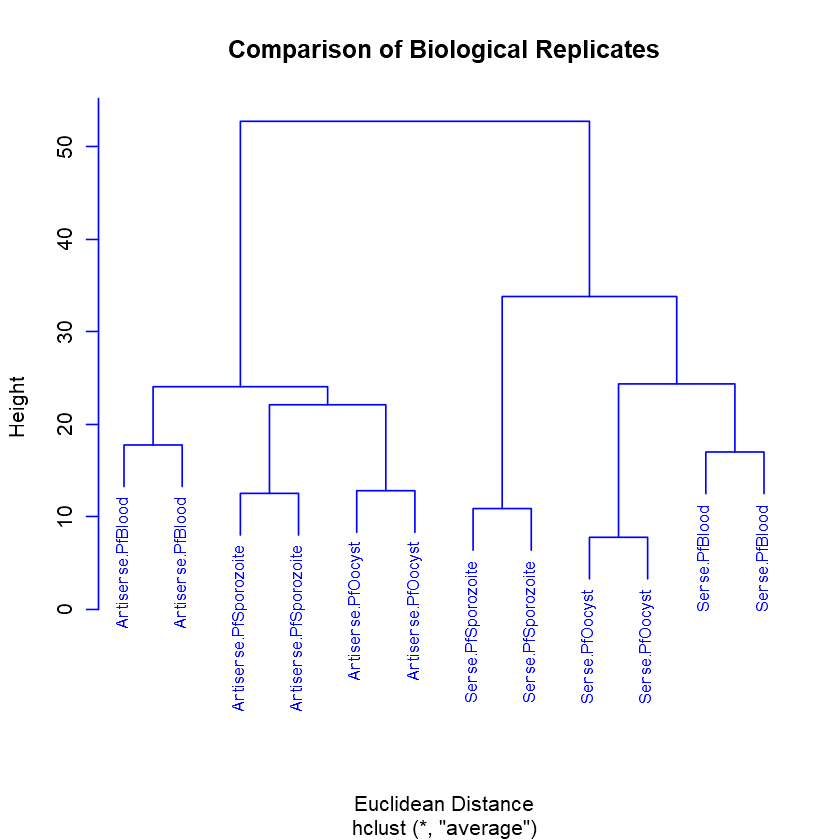

In [177]:
# cal z-score
cluster.dat <- exprs(my.rma)
gene.mean <- apply(cluster.dat, 1, mean)
gene.sd <- apply(cluster.dat, 1, sd)
cluster.dat <- sweep(cluster.dat, 1, gene.mean, "-")
cluster.dat <- sweep(cluster.dat, 1, gene.sd, "/")

my.dist <- dist(t(cluster.dat), method="euclidean")
my.hclust <- hclust(my.dist, method="average")
my.hclust$labels <- pData(my.rma)$group
# svg("results/SamplesPlot/HierarchicalPlot.svg")
plot(my.hclust, cex=0.75,col="blue",
     main="Comparison of Biological Replicates", 
      xlab="Euclidean Distance")
# dev.off()

### Removing Low Expression Data

To reduce the possibility for type I errors is to do fewer comparisons. This can be done by filtering the data. For example, we know that not all genes are expressed in all tissues and many genes will not be expressed in any sample. As a result, DGE analysis, it makes sense to remove probesets for genes that likely not expressed at all.

In [184]:
table(exprs(my.rma)<=0)


FALSE  TRUE 
10808   124 

In [183]:
as.numeric(quantile(exprs(my.rma), c(0., 0.025, 0.05, 0.075, 0.099, .10), na.rm=T))

[1] -1.7574671  0.1988640  0.2930688  0.9555456  1.1988640  1.1988640

***We now have the metadata and phenodata (sample data) for this experiment. The expression data is in format that could be used for differential gene expression (DGE) analysis.***

# DGE with Limma

In [185]:
# check if rows of phenotype is sorted same way as columns of exprs matrix
table(rownames(pData(my.rma))==colnames(exprs(my.rma)))


TRUE 
  12 

## Design Matrix

In [186]:
# prepare design matrix
sample.lst<-pData(my.rma)$group
group.lst<-factor(sample.lst)

my.design <- model.matrix(~0 + group, pData(my.rma))

rownames(my.design) <- sample.lst
colnames(my.design) <- levels(group.lst)

my.design

,Antisense.PfBlood,Antisense.PfOocyst,Antisense.PfSporozoite,Sense.PfBlood,Sense.PfOocyst,Sense.PfSporozoite
Antisense.PfBlood,1,0,0,0,0,0
Antisense.PfBlood,1,0,0,0,0,0
Sense.PfBlood,0,0,0,1,0,0
Sense.PfBlood,0,0,0,1,0,0
Antisense.PfOocyst,0,1,0,0,0,0
Antisense.PfOocyst,0,1,0,0,0,0
Sense.PfOocyst,0,0,0,0,1,0
Sense.PfOocyst,0,0,0,0,1,0
Antisense.PfSporozoite,0,0,1,0,0,0
Antisense.PfSporozoite,0,0,1,0,0,0


In [187]:
# fit linear model
fit <- lmFit(my.rma, my.design)

In [188]:
# specify the comparison btw group of interest
my.contrasts <- makeContrasts(Antisense.Sporozoite_vs_Oocyst = Antisense.PfSporozoite - Antisense.PfOocyst,
                              Antisense.Blood_vs_Oocyst = Antisense.PfBlood - Antisense.PfOocyst,
                              Sense.Sporozoite_vs_Oocyst = Sense.PfSporozoite - Sense.PfOocyst,
                              Sense.Blood_vs_Oocyst = Sense.PfBlood - Sense.PfOocyst
                              , levels = my.design)
my.contrasts

,Antisense.Sporozoite_vs_Oocyst,Antisense.Blood_vs_Oocyst,Sense.Sporozoite_vs_Oocyst,Sense.Blood_vs_Oocyst
Antisense.PfBlood,0,1,0,0
Antisense.PfOocyst,-1,-1,0,0
Antisense.PfSporozoite,1,0,0,0
Sense.PfBlood,0,0,0,1
Sense.PfOocyst,0,0,-1,-1
Sense.PfSporozoite,0,0,1,0


In [189]:
# store comparison matrix
write.table(my.contrasts, file=paste0("results/",my.gse,"_Comparisons.txt"), 
            sep="\t", quote=F,col.names=NA)

## Statistical Inference

In [190]:
fits.fun<-function(x)(contrasts.fit(fit, contrasts=my.contrasts[, x]));

contrast.fits <- lapply(colnames(my.contrasts),fits.fun)
names(contrast.fits)<-colnames(my.contrasts)

In [191]:
ebs.fun<-function(x)(eBayes(x, proportion=0.1, trend=FALSE, robust=FALSE))
    
contrast.ebs <- lapply(contrast.fits, ebs.fun)

In [192]:
tts.fun<-function(x)(topTable(x, adjust.method="BH", number=length(x$coefficients), sort.by="none"));

contrast.tts <- lapply(contrast.ebs,tts.fun)

In [195]:
test.fun<-function(x){
    store<-decideTests(x, method="separate", 
                                  adjust.method="BH", p.value=0.05, 
                                  lfc=0)
    return(store)
};

contrast.tests <- lapply(contrast.ebs, test.fun)


In [196]:
contrast.tests.df<-lapply(contrast.tests,function(x){
    store<-as.data.frame(x)
    colnames(store)<-"test"
    return(store)
})

In [197]:
head(contrast.tests.df[[1]])

,test
,<dbl>
PF3D7_0103900,0
PF3D7_0104300,0
PF3D7_0104800,0
PF3D7_0104900,0
PF3D7_0105600,0
PF3D7_0105700,-1


In [198]:
# show in one matrix whether up or down regulated in diff comparisons
tests.mat <- do.call(cbind, contrast.tests)
colnames(tests.mat) <- names(contrast.tests)
write.table(tests.mat, file=paste0("results/",my.gse,"_Test.txt"), 
            sep="\t", quote=F, col.names=NA)

In [199]:
head(tests.mat,3)

,Antisense.Sporozoite_vs_Oocyst,Antisense.Blood_vs_Oocyst,Sense.Sporozoite_vs_Oocyst,Sense.Blood_vs_Oocyst
PF3D7_0103900,0,0,-1,0
PF3D7_0104300,0,0,1,0
PF3D7_0104800,0,1,1,-1


# Gene Annotations for Microarray Probesets

In [203]:
plasmodium.db<-read.table("geo_downloads/annotation_file.txt",header=T,sep="\t",quote="")
head(plasmodium.db)

,Gene.ID,source_id,Organism,Genomic.Location..Gene.,Product.Description,Gene.Type,Input.ID,Gene.Name.or.Symbol,X
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
1,PF3D7_0103800,PF3D7_0103800.1,Plasmodium falciparum 3D7,"Pf3D7_01_v3:169,079..171,273(-)",actin-related protein,protein coding,PF3D7_0103800,ARP1,NA
2,PF3D7_0103900,PF3D7_0103900.1,Plasmodium falciparum 3D7,"Pf3D7_01_v3:172,864..174,591(+)",parasite-infected erythrocyte surface protein,protein coding,PF3D7_0103900,PIESP15,NA
3,PF3D7_0104000,PF3D7_0104000.1,Plasmodium falciparum 3D7,"Pf3D7_01_v3:175,609..176,376(+)",thrombospondin-related sporozoite protein,protein coding,PF3D7_0104000,TRSP,NA
4,PF3D7_0104100,PF3D7_0104100.1,Plasmodium falciparum 3D7,"Pf3D7_01_v3:178,087..180,790(+)","conserved Plasmodium membrane protein, unknown function",protein coding,PF3D7_0104100,N/A,NA
5,PF3D7_0104200,PF3D7_0104200.1,Plasmodium falciparum 3D7,"Pf3D7_01_v3:182,822..184,222(-)",StAR-related lipid transfer protein,protein coding,PF3D7_0104200,N/A,NA
6,PF3D7_0104300,PF3D7_0104300.1,Plasmodium falciparum 3D7,"Pf3D7_01_v3:190,269..201,230(+)","ubiquitin carboxyl-terminal hydrolase 1, putative",protein coding,PF3D7_0104300,UBP1,NA


In [204]:
plasmodium.db<-plasmodium.db[,c(1:8)]
head(plasmodium.db,2)

,Gene.ID,source_id,Organism,Genomic.Location..Gene.,Product.Description,Gene.Type,Input.ID,Gene.Name.or.Symbol
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,PF3D7_0103800,PF3D7_0103800.1,Plasmodium falciparum 3D7,"Pf3D7_01_v3:169,079..171,273(-)",actin-related protein,protein coding,PF3D7_0103800,ARP1
2,PF3D7_0103900,PF3D7_0103900.1,Plasmodium falciparum 3D7,"Pf3D7_01_v3:172,864..174,591(+)",parasite-infected erythrocyte surface protein,protein coding,PF3D7_0103900,PIESP15


In [206]:
my.annotated.results<-lapply(colnames(my.contrasts),function(x){  
    store<-merge(contrast.tts[[x]], contrast.tests.df[[x]], by="row.names",all.x=FALSE)
    colnames(store)[1]<-"Gene.ID"

    store<-merge(plasmodium.db, store, by="Gene.ID")
    return(store)
})
names(my.annotated.results)<-colnames(my.contrasts)

In [207]:
head(my.annotated.results[[1]],3)

,Gene.ID,source_id,Organism,Genomic.Location..Gene.,Product.Description,Gene.Type,Input.ID,Gene.Name.or.Symbol,logFC,AveExpr,t,P.Value,adj.P.Val,B,test
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,PF3D7_0103900,PF3D7_0103900.1,Plasmodium falciparum 3D7,"Pf3D7_01_v3:172,864..174,591(+)",parasite-infected erythrocyte surface protein,protein coding,PF3D7_0103900,PIESP15,1.28424068,4.380679,2.18143319,0.04807772,0.1226857,-1.838713,0
2,PF3D7_0104300,PF3D7_0104300.1,Plasmodium falciparum 3D7,"Pf3D7_01_v3:190,269..201,230(+)","ubiquitin carboxyl-terminal hydrolase 1, putative",protein coding,PF3D7_0104300,UBP1,0.02531653,5.411802,0.04031415,0.96845429,0.9863073,-3.944303,0
3,PF3D7_0104800,PF3D7_0104800.1,Plasmodium falciparum 3D7,"Pf3D7_01_v3:215,776..217,509(+)","novel putative transporter 1, putative",protein coding,PF3D7_0104800,NPT1,0.18628058,4.559875,0.30608067,0.76438241,0.8781241,-3.896421,0


## Cases of genes with two or more probes, only the most significant ones were used.

In [208]:
my.unique.results <- lapply(colnames(my.contrasts), function(x){
    ordered.result<-my.annotated.results[[x]][order(my.annotated.results[[x]]$Gene.ID,
              my.annotated.results[[x]]$adj.P.Val,decreasing=FALSE),]
    return(ordered.result[!duplicated(ordered.result$Gene.ID),])
})
names(my.unique.results) <- colnames(my.contrasts)

In [209]:
# check if duplication still exists
print(length(my.unique.results[[2]]$Gene.ID))
table(duplicated(my.unique.results[[1]]$Gene.ID))

[1] 908



FALSE 
  908 

## Combine different time point comparison of a strain

In [212]:
colnames(my.unique.results[[1]])

[1] "Gene.ID"                 "source_id"              
 [3] "Organism"                "Genomic.Location..Gene."
 [5] "Product.Description"     "Gene.Type"              
 [7] "Input.ID"                "Gene.Name.or.Symbol"    
 [9] "logFC"                   "AveExpr"                
[11] "t"                       "P.Value"                
[13] "adj.P.Val"               "B"                      
[15] "test"

In [213]:
store.list<-my.unique.results
names<-names(store.list)    
for(x in names){
#     1st comparison
    if(which(x==names)==1){
        combined<-store.list[[x]][,c("Gene.ID","Gene.Name.or.Symbol",'Product.Description',"logFC","test")]
        colnames(combined)[4:5]<-paste(x,c("logFC","test"),sep="_")
        } 
    else{
        colnames(store.list[[x]])<-paste(x,colnames(store.list[[x]]),sep="_")
        colnames(store.list[[x]])[which(colnames(store.list[[x]])==paste(x,"Gene.ID",sep="_"))]<-c("Gene.ID")
        combined<-merge(combined,store.list[[x]][,c(c("Gene.ID"),paste(x,c("logFC","test"),sep="_"))],by="Gene.ID")
        }
}

In [214]:
head(combined,3)

,Gene.ID,Gene.Name.or.Symbol,Product.Description,Antisense.Sporozoite_vs_Oocyst_logFC,Antisense.Sporozoite_vs_Oocyst_test,Antisense.Blood_vs_Oocyst_logFC,Antisense.Blood_vs_Oocyst_test,Sense.Sporozoite_vs_Oocyst_logFC,Sense.Sporozoite_vs_Oocyst_test,Sense.Blood_vs_Oocyst_logFC,Sense.Blood_vs_Oocyst_test
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,PF3D7_0103900,PIESP15,parasite-infected erythrocyte surface protein,1.28424068,0,-1.2296205,0,-2.998170,-1,-0.9045508,0
2,PF3D7_0104300,UBP1,"ubiquitin carboxyl-terminal hydrolase 1, putative",0.02531653,0,-0.4501369,0,2.064605,1,1.0732410,0
3,PF3D7_0104800,NPT1,"novel putative transporter 1, putative",0.18628058,0,1.8423444,1,3.129257,1,-3.5334760,-1


## Filter genes that are significant in atleast one comparison

In [215]:
store.test<- 1*(combined[,grep("test",colnames(combined))]!=0)
# select genes that was significant in atleast one time point 
filtered<-combined[apply(store.test,1,sum)>=1,]
store.logFC<-filtered[,grep("logFC",colnames(filtered))]
# sort genes according in logFC
significant.genes<-filtered[order(apply(store.logFC,1,sum),decreasing=TRUE),]

In [216]:
head(significant.genes,3)

,Gene.ID,Gene.Name.or.Symbol,Product.Description,Antisense.Sporozoite_vs_Oocyst_logFC,Antisense.Sporozoite_vs_Oocyst_test,Antisense.Blood_vs_Oocyst_logFC,Antisense.Blood_vs_Oocyst_test,Sense.Sporozoite_vs_Oocyst_logFC,Sense.Sporozoite_vs_Oocyst_test,Sense.Blood_vs_Oocyst_logFC,Sense.Blood_vs_Oocyst_test
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
769,PF3D7_1361800,GAC,glideosome-associated connector,6.283890,1,4.2047908,1,10.97702,1,6.869880,1
656,PF3D7_1238000,N/A,"COPI associated protein, putative",4.169173,1,0.8261336,0,11.21719,1,7.056527,1
725,PF3D7_1335900,TRAP,thrombospondin-related anonymous protein,7.295537,1,-0.8275806,0,13.48028,1,2.194066,1


In [217]:
# store results
write.table(significant.genes, 
            file=paste0("results/","SignificantGenes.txt"), 
                sep="\t", quote=F, row.names=FALSE)

# Visualizing the Results

The function plotMA will produce a scatter plot of average log2 expression on the x-axis vs. log2 fold change on the y-axis.

## MAPlot 

In [218]:
create.folders("results/SamplesPlot/MAPlot")

[1] TRUE

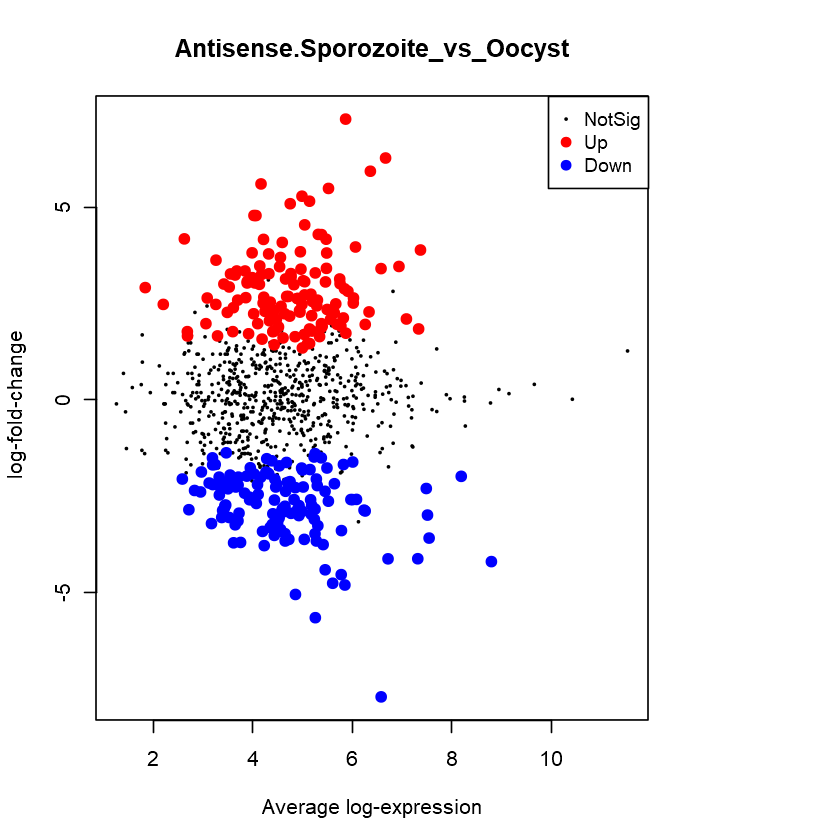

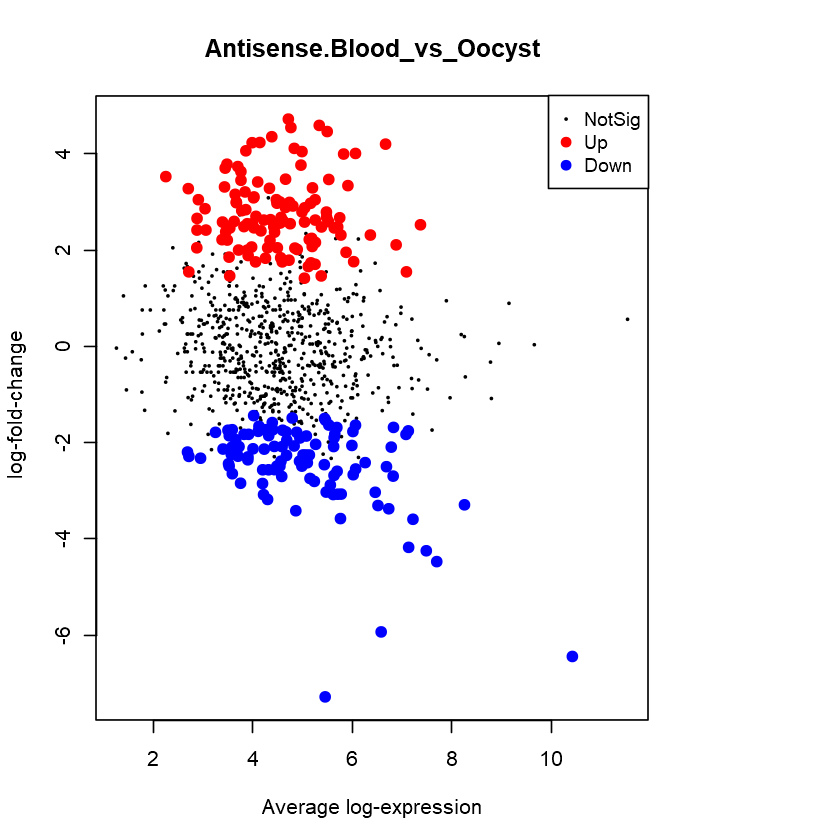

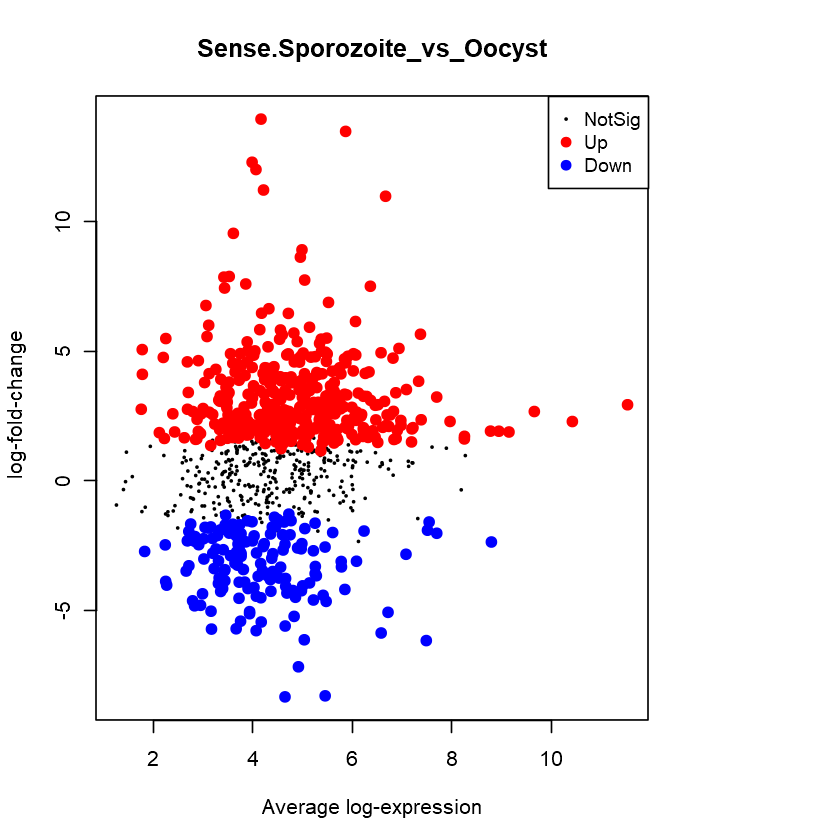

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

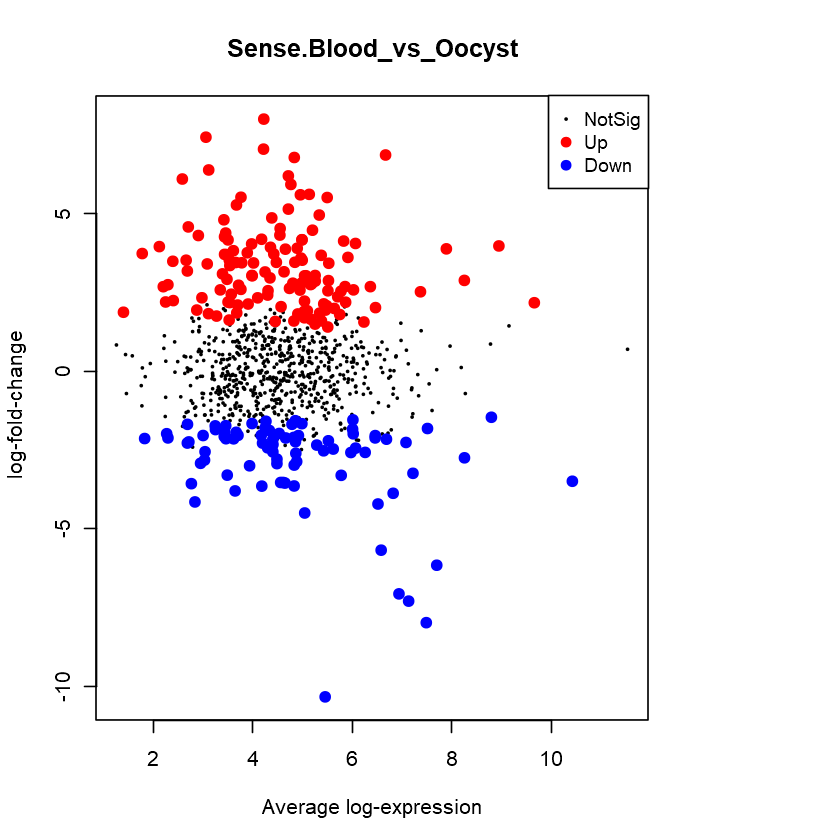

In [222]:
# chosing different color for up, down and not regulated probes, using tests 1,-1,0 marking.
ma.cols <- c(brewer.pal(11, "RdBu")[10], "grey50", brewer.pal(11, "RdBu")[2])
names(ma.cols)<-c(-1,0,1)

names<-names(my.unique.results)
lapply(names,function(x){
    
#     svg(file=paste0("results/SamplesPlot/MAPlot/",x,"_MAPlot.svg"))  
    par(mar=c(5,4,4,8),xpd=TRUE)
        # assign above color to the rows,probeids.
    row.colors <- unname(ma.cols[as.character(contrast.tests[[x]][, 1])])
        
    limma::plotMA(contrast.ebs[[x]], status=contrast.tests[[x]],
                col=row.colors, pch=19, main=x)  
#         abline(h=1,col="red")
#         abline(h=-1,col="blue" )
#         dev.off()
    })

## Volcano Plot

volcano plot which plot logFC on the x-axis and p-value (-log10) on the y-axis.

In [223]:
create.folders("results/SamplesPlot/VolcanoPlot")

[1] TRUE

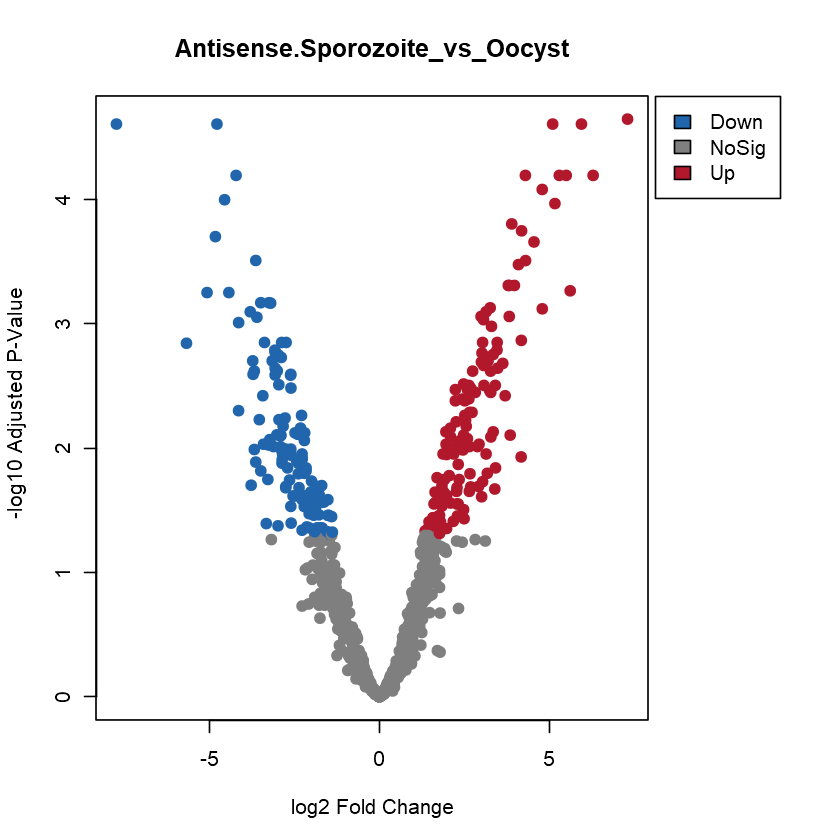

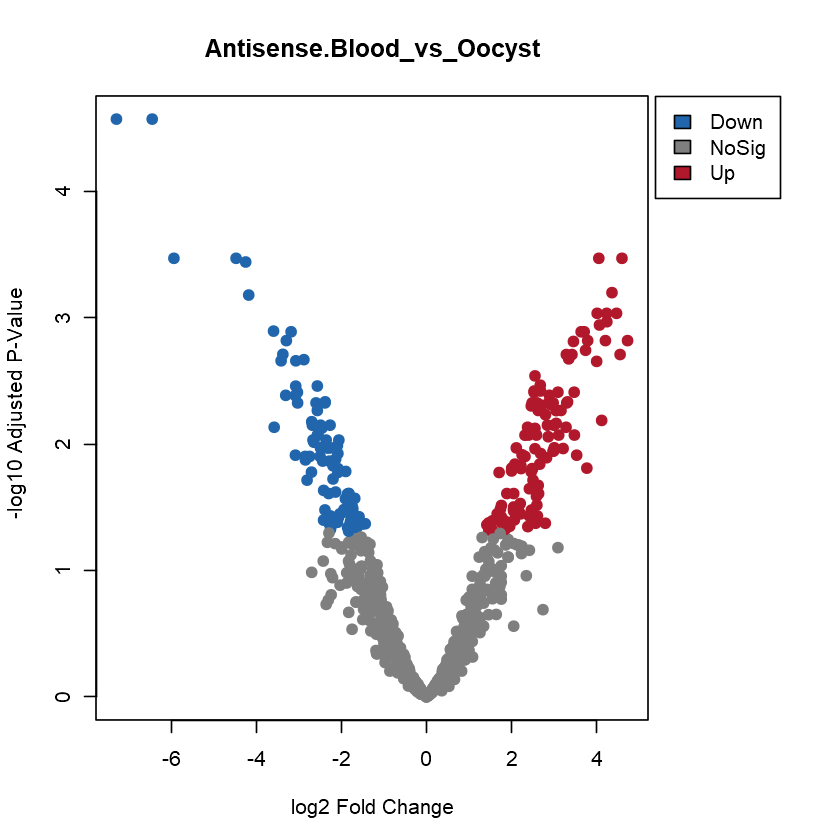

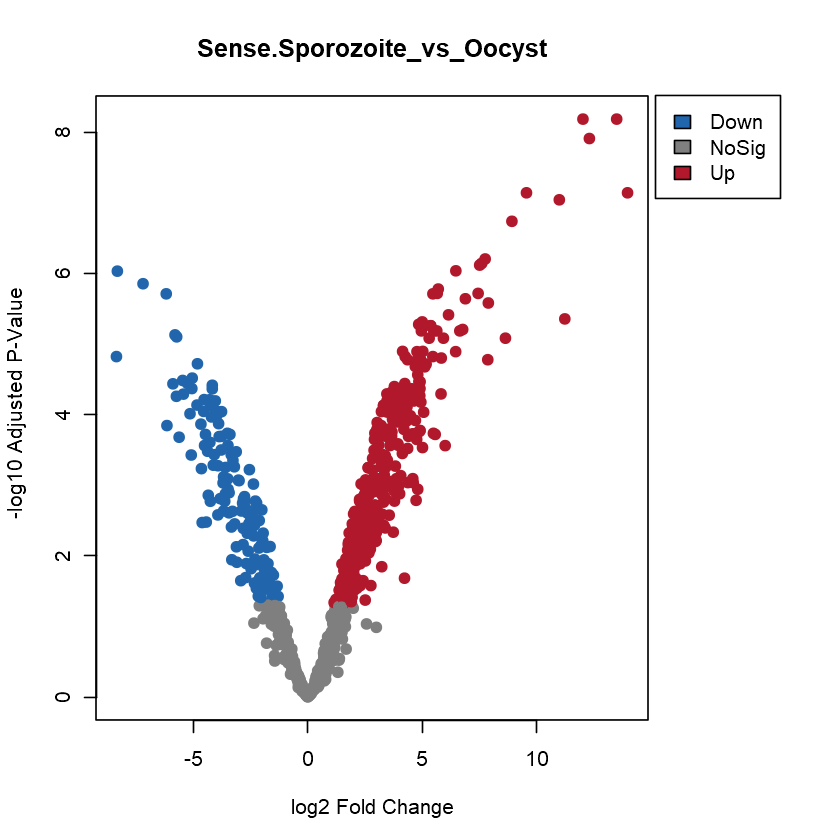

[[1]]
[[1]]$rect
[[1]]$rect$w
[1] 3.676735

[[1]]$rect$h
[1] 0.8251196

[[1]]$rect$left
[1] 8.112071

[[1]]$rect$top
[1] 4.833797


[[1]]$text
[[1]]$text$x
[1] 9.708632 9.708632 9.708632

[[1]]$text$y
[1] 4.627517 4.421237 4.214957



[[2]]
[[2]]$rect
[[2]]$rect$w
[1] 2.940447

[[2]]$rect$h
[1] 0.8114174

[[2]]$rect$left
[1] 5.37813

[[2]]$rect$top
[1] 4.753355


[[2]]$text
[[2]]$text$x
[1] 6.65497 6.65497 6.65497

[[2]]$text$y
[1] 4.550501 4.347646 4.144792



[[3]]
[[3]]$rect
[[3]]$rect$w
[1] 5.460476

[[3]]$rect$h
[1] 1.452684

[[3]]$rect$left
[1] 15.16743

[[3]]$rect$top
[1] 8.512303


[[3]]$text
[[3]]$text$x
[1] 17.53855 17.53855 17.53855

[[3]]$text$y
[1] 8.149132 7.785961 7.422790



[[4]]
[[4]]$rect
[[4]]$rect$w
[1] 4.493823

[[4]]$rect$h
[1] 1.086126

[[4]]$rect$left
[1] 9.008499

[[4]]$rect$top
[1] 6.363915


[[4]]$text
[[4]]$text$x
[1] 10.95987 10.95987 10.95987

[[4]]$text$y
[1] 6.092383 5.820852 5.549320

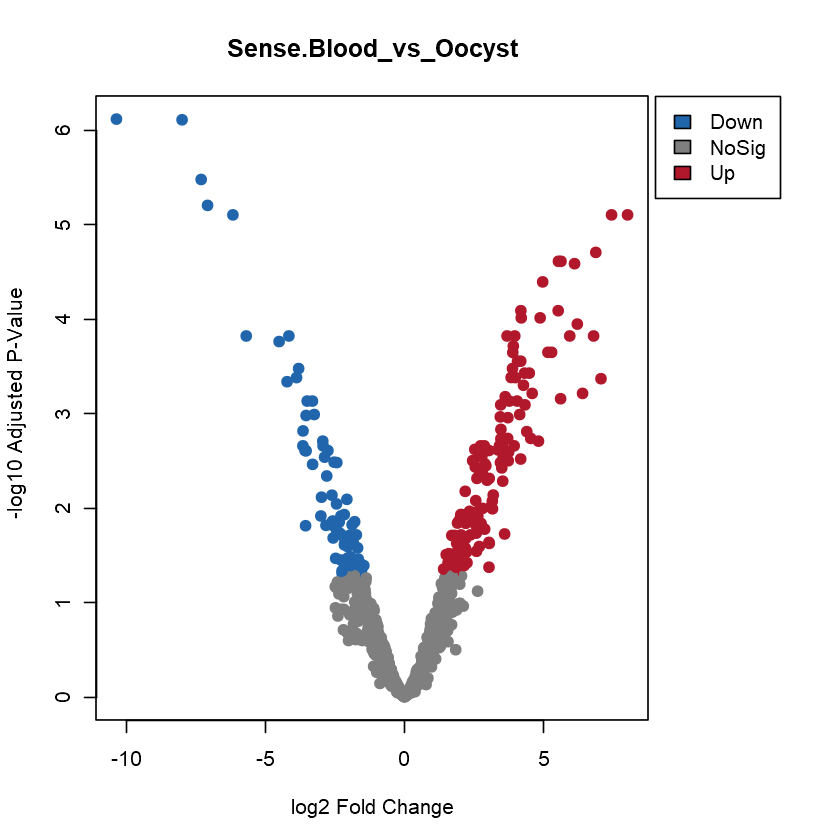

In [226]:
# chosing different color for up, down and not regulated probes.
ma.cols <- c(brewer.pal(11, "RdBu")[10], "grey50", brewer.pal(11, "RdBu")[2])
names(ma.cols)<-c(-1,0,1)

names<-names(my.unique.results)
lapply(names,function(x){
    
#         svg(file=paste0("results/SamplesPlot/VolcanoPlot/",x,"_VolcanoPlot.svg"))
        par(mar=c(5,4,4,8),xpd=TRUE)
        
        legend<-c("Down","NoSig","Up")  
        row.colors <- unname(ma.cols[as.character(contrast.tests[[x]][, 1])])
        
        plot(contrast.tts[[x]]$logFC, 
             -log10(contrast.tts[[x]]$adj.P.Val), 
             col=row.colors, pch=19, main=x, 
             xlab="log2 Fold Change", ylab="-log10 Adjusted P-Value")
#         abline(h=-log10(0.05))
#         abline(v=1,col="red")
#         abline(v=-1,col="blue")
        legend("topright",inset=c(-0.24,0), legend=legend, 
               fill=unname(ma.cols))
#         dev.off()
    })

## Histone and associated Genes

In [57]:
filter_genes<-read.table(file=paste0("assets/histone_related_genes.txt")
                              ,header=T,sep="\t",quote="")

In [58]:
head(filter_genes,10)

,Gene.Name.or.Symbol,isHistoneEnzyme
,<chr>,<int>
1,GCN5A,1
2,GCN5B,1
3,HDAC1,1
4,HDAC2,1
5,HDAC3,1
6,HDAC5,1
7,MYSTA,1
8,MYSTB,1
9,SIR2,1


In [59]:
new_filter_genes<- merge(filter_genes,new_toxo.db,by="Gene.Name.or.Symbol")
head(new_filter_genes,3)

,Gene.Name.or.Symbol,isHistoneEnzyme,ToxoDB_ID,Gene.ID,ID
,<chr>,<int>,<chr>,<chr>,<chr>
1,AP2III1,0,52.m01544,TGME49_252370,52.m01544_at
2,AP2III2,0,52.m01583,TGME49_253380,52.m01583_at
3,AP2III3,0,129.m00257,TGME49_299150,129.m00257_at


In [60]:
filter_ids<-as.data.frame(new_filter_genes[!duplicated(new_filter_genes$Gene.ID),]$Gene.ID)
colnames(filter_ids)<-c("Gene.ID")
head(filter_ids)

,Gene.ID
,<chr>
1,TGME49_252370
2,TGME49_253380
3,TGME49_299150
4,TGME49_320700
5,TGME49_320680
6,TGME49_211720


In [61]:
combined_filter_genes<-merge(combined,filter_ids,by="Gene.ID")
head(combined_filter_genes,5)

,Gene.ID,ToxoDB_ID,Gene.Name.or.Symbol,Oocyst_4vs0d_logFC,Oocyst_4vs0d_test,Oocyst_10vs0d_logFC,Oocyst_10vs0d_test,Tachy_2dpi_vitro_vs_Oocyst_0d_logFC,Tachy_2dpi_vitro_vs_Oocyst_0d_test,Brady_4dpi_vitro_vs_Oocyst_0d_logFC,Brady_4dpi_vitro_vs_Oocyst_0d_test,Brady_8dpi_vitro_vs_Oocyst_0d_logFC,Brady_8dpi_vitro_vs_Oocyst_0d_test,Brady_21dpi_vivo_vs_Oocyst_0d_logFC,Brady_21dpi_vivo_vs_Oocyst_0d_test
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TGME49_202230,20.m03703,HDAC5,1.0784934,1,1.3156164,1,0.5059929,0,0.4012351,0,0.0826171,0,0.6450192,0
2,TGME49_202490,20.m03722,AP2VIIA7,-0.8727921,-1,-1.0788617,-1,-0.7655035,-1,-0.9435666,-1,-0.8761218,-1,-0.7073690,-1
3,TGME49_203690,20.m03816,AP2VIIA5,-0.4475332,0,-0.4156011,0,-0.7405226,-1,-1.2035390,-1,-0.9096815,-1,-1.0098146,-1
4,TGME49_203710,20.m03817,AP2VIIA4,0.1029488,0,-0.2325817,0,0.2890355,0,0.3179921,0,0.7379475,1,0.4106464,0
5,TGME49_205650,20.m00367,AP2VIIA3,0.3739884,0,-0.2023472,0,1.5038196,1,1.6534687,1,1.5811440,1,1.3071966,1


In [69]:
getwd()

[1] "D:/biological data analysis/Parasites/Plasmodium falciparum 3D7/GSE32427"

In [70]:
write.table(combined_filter_genes, 
            file=paste0("results/",my.gse,"_HistoneRelatedGenes.txt"), 
            sep="\t", quote=F, row.names=FALSE)

In [63]:
significant_filter_genes<-merge(significant.genes,
                                          filter_ids,
                                           by="Gene.ID")
head(significant_filter_genes,5)

,Gene.ID,ToxoDB_ID,Gene.Name.or.Symbol,Oocyst_4vs0d_logFC,Oocyst_4vs0d_test,Oocyst_10vs0d_logFC,Oocyst_10vs0d_test,Tachy_2dpi_vitro_vs_Oocyst_0d_logFC,Tachy_2dpi_vitro_vs_Oocyst_0d_test,Brady_4dpi_vitro_vs_Oocyst_0d_logFC,Brady_4dpi_vitro_vs_Oocyst_0d_test,Brady_8dpi_vitro_vs_Oocyst_0d_logFC,Brady_8dpi_vitro_vs_Oocyst_0d_test,Brady_21dpi_vivo_vs_Oocyst_0d_logFC,Brady_21dpi_vivo_vs_Oocyst_0d_test
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TGME49_202230,20.m03703,HDAC5,1.0784934,1,1.3156164,1,0.5059929,0,0.4012351,0,0.0826171,0,0.6450192,0
2,TGME49_202490,20.m03722,AP2VIIA7,-0.8727921,-1,-1.0788617,-1,-0.7655035,-1,-0.9435666,-1,-0.8761218,-1,-0.7073690,-1
3,TGME49_203690,20.m03816,AP2VIIA5,-0.4475332,0,-0.4156011,0,-0.7405226,-1,-1.2035390,-1,-0.9096815,-1,-1.0098146,-1
4,TGME49_203710,20.m03817,AP2VIIA4,0.1029488,0,-0.2325817,0,0.2890355,0,0.3179921,0,0.7379475,1,0.4106464,0
5,TGME49_205650,20.m00367,AP2VIIA3,0.3739884,0,-0.2023472,0,1.5038196,1,1.6534687,1,1.5811440,1,1.3071966,1


In [64]:
dim(significant_filter_genes)

[1] 52 15

In [71]:
write.table(significant_filter_genes, 
                file=paste0("results/",my.gse,"_SignificantHistoneRelatedGenes.txt"), 
            sep="\t", quote=F, row.names=FALSE)

## ScatterPlot<br>
We separed histone genes and converted it to suitable format for ggplot inside excel sheet

In [1]:
library(ggplot2)

In [2]:
library(repr)

In [4]:
# setwd('GSE68667_P.falci_mosquito/')
getwd()

[1] "D:/biological data analysis/Parasites/GSE68667_P.falci_mosquito"

In [5]:
only.histo<-read.table("results/P.falciparum_histo_genes_ggplot.txt",header=T,sep="\t",quote="")
head(only.histo,5)

,Gene.ID,Symbol,Product.Description,logFC,test,stage,direction
,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>
1,PF3D7_1472200,HDA1,"""histone deacetylase, putative""",-1.2119179,0,asexual blood stage,Antisense
2,PF3D7_0629700,SET1,"""SET domain protein, putative""",-0.3741353,0,asexual blood stage,Antisense
3,PF3D7_1322100,SET2,histone-lysine N-methyltransferase SET2,-1.0147784,0,asexual blood stage,Antisense
4,PF3D7_1115200,SET7,histone-lysine N-methyltransferase SET7,3.4705143,1,asexual blood stage,Antisense
5,PF3D7_0403900,SET8,"""SET domain protein, putative""",2.5498631,1,asexual blood stage,Antisense


In [6]:
only.antisense.histo<-only.histo[only.histo$direction=='Antisense',]
head(only.antisense.histo,5)

,Gene.ID,Symbol,Product.Description,logFC,test,stage,direction
,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>
1,PF3D7_1472200,HDA1,"""histone deacetylase, putative""",-1.2119179,0,asexual blood stage,Antisense
2,PF3D7_0629700,SET1,"""SET domain protein, putative""",-0.3741353,0,asexual blood stage,Antisense
3,PF3D7_1322100,SET2,histone-lysine N-methyltransferase SET2,-1.0147784,0,asexual blood stage,Antisense
4,PF3D7_1115200,SET7,histone-lysine N-methyltransferase SET7,3.4705143,1,asexual blood stage,Antisense
5,PF3D7_0403900,SET8,"""SET domain protein, putative""",2.5498631,1,asexual blood stage,Antisense


In [7]:
only.sense.histo<-only.histo[only.histo$direction=='Sense',]
head(only.sense.histo,5)

,Gene.ID,Symbol,Product.Description,logFC,test,stage,direction
,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>
7,PF3D7_1472200,HDA1,"""histone deacetylase, putative""",0.5646268,0,asexual blood stage,Sense
8,PF3D7_0629700,SET1,"""SET domain protein, putative""",0.5887547,0,asexual blood stage,Sense
9,PF3D7_1322100,SET2,histone-lysine N-methyltransferase SET2,-0.0489323,0,asexual blood stage,Sense
10,PF3D7_1115200,SET7,histone-lysine N-methyltransferase SET7,3.4313123,1,asexual blood stage,Sense
11,PF3D7_0403900,SET8,"""SET domain protein, putative""",3.7643362,1,asexual blood stage,Sense


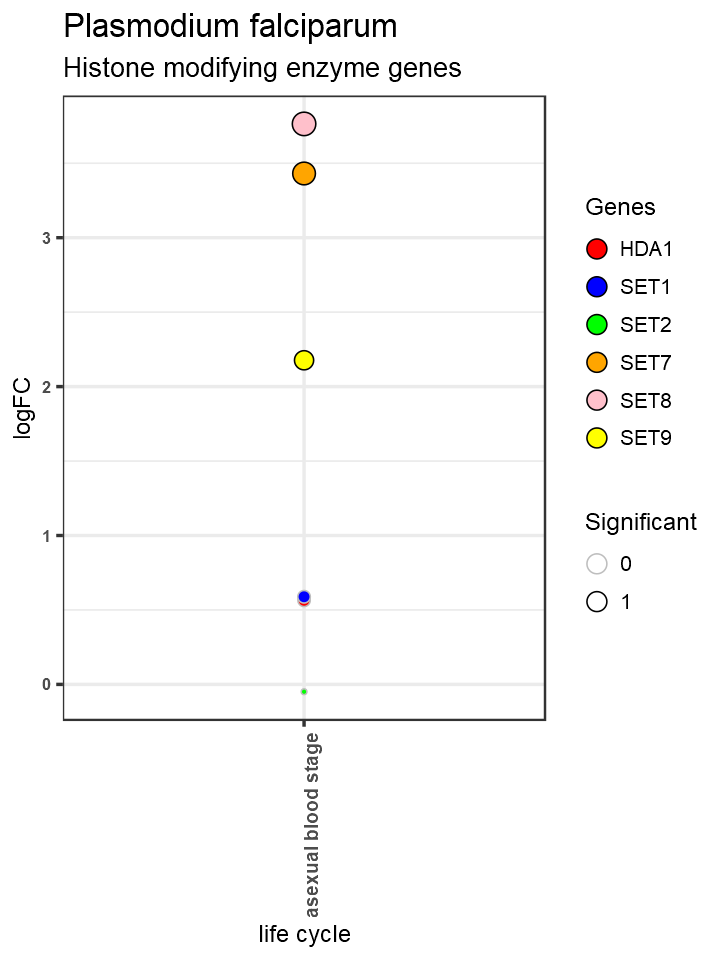

In [12]:
# svg(file="results/HistoneRelatedPLot.svg") 
options(repr.plot.width=6,repr.plot.height=8)

theme_set(theme_bw(base_size = 16))  # pre-set the bw theme.
x_axis_order<-c('asexual blood stage')
size<-abs(only.sense.histo$logFC)
Significant<-factor(only.sense.histo$test)
Genes<-only.sense.histo$Symbol
gene.cols <- c("HDA1" = "red", "SET1" = "blue", "SET2" = "green", "SET7" = "orange",
              "SET8"="pink", "SET9"="yellow")
g <- ggplot(only.sense.histo, aes(factor(stage, level = x_axis_order),
                                   logFC))+
    geom_point(aes(fill=Genes,size=size,col=Significant),shape=21) +

#     scale_colour_manual(values = c("black", "gray", "black"))+
    scale_colour_manual(values = c("gray", "black"))+
    scale_fill_manual(values=gene.cols)+

    guides(size = FALSE, fill = guide_legend(override.aes = list(size=5)),
          color = guide_legend(override.aes = list(size=5)))+
    theme(axis.text.x = element_text(face="bold",size=11,angle=90),
          axis.text.y = element_text(face="bold",size=10),
          legend.title = element_text(color="black",size = 14),
          legend.text = element_text(color = "black", size = 12),
          legend.key.size = unit(0.8, "cm"),
#           legend.key.size = unit(3,"line"),
          legend.key.width = unit(0.5,"cm") ,
        axis.text=element_text(size=12),
        axis.title=element_text(size=14),
          
          )+
  labs(subtitle="Histone modifying enzyme genes", 
       y="logFC",
       x="life cycle",
       title="Plasmodium falciparum"
#        caption="life cycle"
      )
g
# dev.off()

In [13]:
ggsave(file="results/OnlyHistonePlot.svg", plot=g, width=6, height=8)
# ggsave(file="results/OnlyHistonePlot_Sense.svg", plot=g)

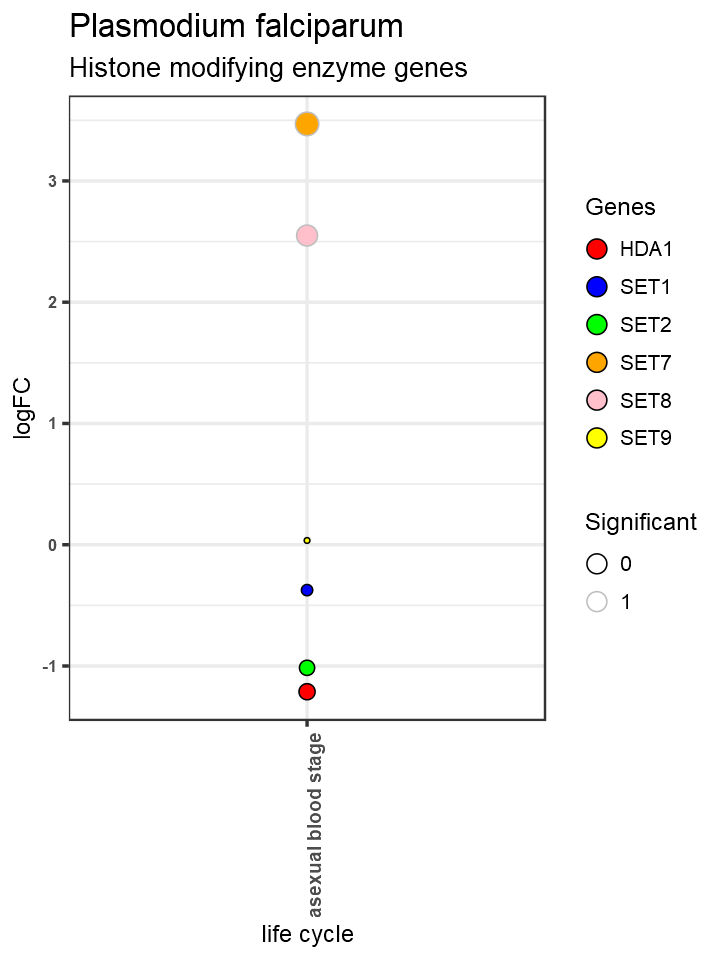

In [14]:
# svg(file="results/HistoneRelatedPLot.svg") 
options(repr.plot.width=6,repr.plot.height=8)

theme_set(theme_bw(base_size = 16))  # pre-set the bw theme.
x_axis_order<-c('asexual blood stage')
size<-abs(only.antisense.histo$logFC)
Significant<-factor(only.antisense.histo$test)
Genes<-only.antisense.histo$Symbol
gene.cols <- c("HDA1" = "red", "SET1" = "blue", "SET2" = "green", "SET7" = "orange",
              "SET8"="pink", "SET9"="yellow")
g <- ggplot(only.antisense.histo, aes(factor(stage, level = x_axis_order),
                                   logFC))+
    geom_point(aes(fill=Genes,size=size,col=Significant),shape=21) +

    scale_colour_manual(values = c("black", "gray", "black"))+
    scale_fill_manual(values=gene.cols)+

    guides(size = FALSE, fill = guide_legend(override.aes = list(size=5)),
          color = guide_legend(override.aes = list(size=5)))+
    theme(axis.text.x = element_text(face="bold",size=11,angle=90),
          axis.text.y = element_text(face="bold",size=10),
          legend.title = element_text(color="black",size = 14),
          legend.text = element_text(color = "black", size = 12),
          legend.key.size = unit(0.8, "cm"),
#           legend.key.size = unit(3,"line"),
          legend.key.width = unit(0.5,"cm") ,
        axis.text=element_text(size=12),
        axis.title=element_text(size=14),
          
          )+
  labs(subtitle="Histone modifying enzyme genes", 
       y="logFC",
       x="life cycle",
       title="Plasmodium falciparum"
#        caption="life cycle"
      )
g
# dev.off()

In [15]:
ggsave(file="results/OnlyHistonePlot_Antisense.svg", plot=g, width=6, height=8)